In [1]:
# USAGE
# python region_proposal_detection.py --image beagle.png

# import the necessary packages
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.preprocessing.image import img_to_array
from imutils.object_detection import non_max_suppression

import numpy as np
import argparse
import cv2

import matplotlib.pyplot as plt


In [1]:
# Example execution
args = dict()
args['image'] = 'data/test.jpg'
args['method'] = 'fast'   # Other choice is quality
args['conf'] = 0.9
args['filter'] = None

In [3]:
def selective_search(image, method="fast"):
	# initialize OpenCV's selective search implementation and set the
	# input image
	ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
	ss.setBaseImage(image)

	# check to see if we are using the *fast* but *less accurate* version
	# of selective search
	if method == "fast":
		ss.switchToSelectiveSearchFast()

	# otherwise we are using the *slower* but *more accurate* version
	else:
		ss.switchToSelectiveSearchQuality()

	# run selective search on the input image
	rects = ss.process()

	# return the region proposal bounding boxes
	return rects

In [4]:
# speed-up using multithreads
#cv2.setUseOptimized(True);
#cv2.setNumThreads(4);

args['method'] = 'fast'   # Other choice is quality

# load the input image from disk and grab its dimensions
image = cv2.imread(args['image'])
(H, W) = image.shape[:2]

# run selective search on the input image
print("[INFO] performing selective search with '{}' method...".format(
	args["method"]))

e1 = cv2.getTickCount()
rects = selective_search(image, method=args["method"])
e2 = cv2.getTickCount()

time = (e2 - e1)/ cv2.getTickFrequency()

print( time, "seconds")


print("[INFO] {} regions found by selective search".format(len(rects)))

selectiveWindowsFast = len(rects)
# get number of windows for the quality selective search
rects = selective_search(image, method='quality')
selectiveWindowsQuality = len(rects)

[INFO] performing selective search with 'fast' method...
2.163592086 seconds
[INFO] 2489 regions found by selective search


In [5]:
def windowSearch(windowSize, S, image):
    
    # create a new list for rectangles to be used by the roi function later
    rects = []
    
    # loop through the entire image by stride S and add this rectangle to the list
    for y in range(0, (image.shape[0] - windowSize[0]), S):
        for x in range(0, (image.shape[1] - windowSize[1]), S):
            rects.append((x, y, windowSize[0], windowSize[1]))
    
    return rects

[215158, 53879, 13590, 3420, 874, 228]  Number of Window Search Windows Found
2489  Number of Selective Search Fast Windows Found
9936  Number of Selective Search Quality Windows Found


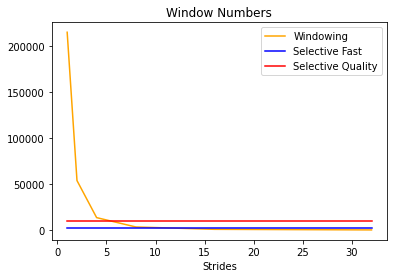

In [6]:
S = [1, 2, 4, 8, 16, 32]
windowSize = (128, 128)
numWindows = []
for stride in S:
    numWindows.append(len(windowSearch(windowSize, stride, image)))

print(numWindows, ' Number of Window Search Windows Found')
print(selectiveWindowsFast, ' Number of Selective Search Fast Windows Found')
print(selectiveWindowsQuality, ' Number of Selective Search Quality Windows Found')


plt.title('Window Numbers')
plt.xlabel('Strides')
plt.plot(S, numWindows, color='orange', label='Windowing')
plt.plot(S, [selectiveWindowsFast for x in range(0, len(S))], color='blue', label='Selective Fast')
plt.plot(S, [selectiveWindowsQuality for x in range(0, len(S))], color='red', label='Selective Quality')
plt.legend()
plt.show()

### Preliminary Testing Results

So far we found the number of windows to use for our classifier in the future. We can see the selective search takes a much longer time to create a list of search areas, however the list tends to be shorter than the smaller strides of the windowing approach. Using a very small stride shows an extremely large amount of windows to be searched and would later slow down our classifier as it has a lot more to sift through

In [7]:
def roiFilter(rects, size=(224, 224)):
    # initialize the list of region proposals that we'll be classifying
    # along with their associated bounding boxes
    proposals = []
    boxes = []

    # loop over the region proposal bounding box coordinates generated by
    # running selective search
    for (x, y, w, h) in rects:
        # if the width or height of the region is less than 10% of the
        # image width or height, ignore it (i.e., filter out small
        # objects that are likely false-positives)
        if w / float(W) < 0.1 or h / float(H) < 0.1:
            continue

        # extract the region from the input image, convert it from BGR to
        # RGB channel ordering, and then resize it to 224x224 (the input
        # dimensions required by our pre-trained CNN)
        roi = image[y:y + h, x:x + w]
        roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
        roi = cv2.resize(roi, size)

        # further preprocess by the ROI
        roi = img_to_array(roi)
        roi = preprocess_input(roi)

        # update our proposals and bounding boxes lists
        proposals.append(roi)
        boxes.append((x, y, w, h))

    # convert the proposals list into NumPy array and show its dimensions
    proposals = np.array(proposals)
    print("[INFO] proposal shape: {}".format(proposals.shape))
    
    return proposals, boxes

In [8]:
# grab the label filters command line argument
labelFilters = args["filter"]

# if the label filter is not empty, break it into a list
if labelFilters is not None:
	labelFilters = labelFilters.lower().split(",")
    
# load ResNet from disk (with weights pre-trained on ImageNet)
print("[INFO] loading ResNet...")
model = ResNet50(weights="imagenet")

[INFO] loading ResNet...


In [9]:
# Setting this will limit the search to just one category
labelFilters = ['beagle']
confidence = args["conf"]     # 0.90 is the default from args

In [23]:
def labelBoxes(preds, boxes, labelFilters, confidence):
    # initialize a dictionary which maps class labels (keys) to any
    # bounding box associated with that label (values)
    labels = {}
    filterRemoved = 0
        
    # loop over the predictions
    for (i, p) in enumerate(preds):
        # grab the prediction information for the current region proposal
        (imagenetID, label, prob) = p[0]

        # only if the label filters are not empty *and* the label does not
        # exist in the list, then ignore it
        if labelFilters is not None and label not in labelFilters:
            filterRemoved = filterRemoved + 1
            continue

        # filter out weak detections by ensuring the predicted probability
        # is greater than the minimum probability
        if prob >= confidence:
            # grab the bounding box associated with the prediction and
            # convert the coordinates
            (x, y, w, h) = boxes[i]
            box = (x, y, x + w, y + h)

            # grab the list of predictions for the label and add the
            # bounding box + probability to the list
            L = labels.get(label, [])
            L.append((box, prob))
            labels[label] = L

    return labels, filterRemoved

In [11]:
# create lists to keep track of the amount of regions we are interested in
selectiveWindowsFast = []
selectiveWindowsQuality = []

# --- Test the Fast setting ---
rects = selective_search(image, method='fast')
selectiveWindowsFast.append(len(rects))
proposals, boxes = roiFilter(rects)
selectiveWindowsFast.append(len(proposals))

# classify each of the proposal ROIs using ResNet and then decode the
# predictions
print("[INFO] classifying proposals...")
preds = model.predict(proposals)
preds = imagenet_utils.decode_predictions(preds, top=1)

labels, numRemoved = labelBoxes(preds, boxes, labelFilters, confidence)
# keep track of the number of proposals after filtering labels
selectiveWindowsFast.append(selectiveWindowsFast[-1] - numRemoved)
selectiveWindowsFast.append(len(labels['beagle']))
# Run non-max supression
for label in labels.keys():
    boxes = np.array([p[0] for p in labels[label]])
    proba = np.array([p[1] for p in labels[label]])
    boxes = non_max_suppression(boxes, proba)
selectiveWindowsFast.append(len(boxes))


# --- Test the quality setting ---
rects = selective_search(image, method='quality')
selectiveWindowsQuality.append(len(rects))
proposals, boxes = roiFilter(rects)

# classify each of the proposal ROIs using ResNet and then decode the
# predictions
print("[INFO] classifying proposals...")
preds = model.predict(proposals)
preds = imagenet_utils.decode_predictions(preds, top=1)

selectiveWindowsQuality.append(len(proposals))
labels, numRemoved = labelBoxes(preds, boxes, labelFilters, confidence)
selectiveWindowsQuality.append(selectiveWindowsQuality[-1] - numRemoved)
selectiveWindowsQuality.append(len(labels['beagle']))
# Run non-max supression
for label in labels.keys():
    boxes = np.array([p[0] for p in labels[label]])
    proba = np.array([p[1] for p in labels[label]])
    boxes = non_max_suppression(boxes, proba)
selectiveWindowsQuality.append(len(boxes))

print(selectiveWindowsFast, ' Regions at each stage Fast')
print(selectiveWindowsQuality, ' Regions at each stage Quality')

[INFO] proposal shape: (877, 224, 224, 3)
[INFO] classifying proposals...
[INFO] proposal shape: (4173, 224, 224, 3)
[INFO] classifying proposals...
[2489, 877, 167, 31, 3]  Regions at each stage Fast
[9936, 4173, 1054, 245, 3]  Regions at each stage Quality


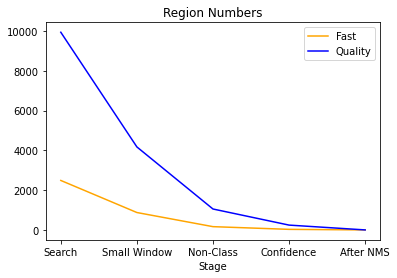

In [12]:
stages = ['Search', 'Small Window', 'Non-Class', 'Confidence', 'After NMS']
plt.title('Region Numbers')
plt.xlabel('Stage')
plt.plot(stages, selectiveWindowsFast, color='orange', label='Fast')
plt.plot(stages, selectiveWindowsQuality, color='blue', label='Quality')
plt.legend()
plt.show()

### Region analysis
We started by running the selective search and then slowly widdling the results down futher step by step. The above graph shows the number of regions we're interested in at each step. Interestingly enough, we observe that both the fast and the quality reduced down to the same number of final regions at the end even though it was very obvious while running the code how much faster the "fast" setting was at completing the task. We will explore this timing further later.

In [13]:
confidenceFast = []
confidenceQuality = []
confidence = [0.7, 0.74, 0.78, 0.81, 0.84, 0.87, 0.90, 0.93, 0.96, 0.99]

rects = selective_search(image, method='fast')
proposals, boxes = roiFilter(rects)
# classify each of the proposal ROIs using ResNet and then decode the
# predictions
preds = model.predict(proposals)
preds = imagenet_utils.decode_predictions(preds, top=1)
for conf in confidence:
    labels, _ = labelBoxes(preds, boxes, labelFilters, conf)
    try:
        confidenceFast.append(len(labels['beagle']))
    except:
        confidenceFast.append(0)
        

rects = selective_search(image, method='quality')
proposals, boxes = roiFilter(rects)
# classify each of the proposal ROIs using ResNet and then decode the
# predictions
preds = model.predict(proposals)
preds = imagenet_utils.decode_predictions(preds, top=1)
for conf in confidence:
    labels, _ = labelBoxes(preds, boxes, labelFilters, conf)
    try:
        confidenceQuality.append(len(labels['beagle']))
    except:
        confidenceQuality.append(0)

[INFO] proposal shape: (877, 224, 224, 3)
[INFO] proposal shape: (4173, 224, 224, 3)


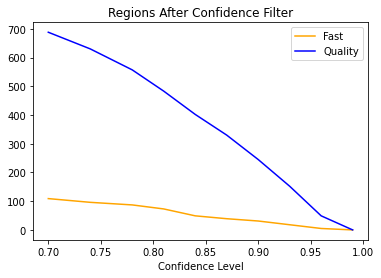

In [14]:
plt.title('Regions After Confidence Filter')
plt.xlabel('Confidence Level')
plt.plot(confidence, confidenceFast, color='orange', label='Fast')
plt.plot(confidence, confidenceQuality, color='blue', label='Quality')
plt.legend()
plt.show()

### Confidence Effect on Regions
Here we cycled through many options for the level of confidence we wanted to rule out boxes that don't meet this level. It was tested with both the 'fast' and 'quality' versions of the selective search algorithm. As can be seen in the above graph, we observe a close to linear relationship between the number of regions still left, and the confidence level we required. It turns out a confidence level of 0.99 was too high for both as they no longer had any regions left that were above this level.

In [15]:
# receives in two lists of tuples
# [(min corner), (max corner)]
def IOU(ground_truth, prediction):
    
    # find our min/max values of the corners to find differences for intersection
    minX = min(ground_truth[1][0], prediction[1][0])
    minY = min(ground_truth[1][1], prediction[1][1])

    maxX = max(ground_truth[0][0], prediction[0][0])
    maxY = max(ground_truth[0][1], prediction[0][1])

    # max calculation catches if there is no intersection
    intArea = max(0, (minX - maxX)) * max(0, (minY - maxY))

    # calculate the area of the two rectangles using the differences beterrn corners
    truthArea = (ground_truth[1][0] - ground_truth[0][0]) * (ground_truth[1][1] - ground_truth[0][1])
    predictArea = (prediction[1][0] - prediction[0][0]) * (prediction[1][1] - prediction[0][1])

    # union area equals both areas minus intersection area
    unionArea = truthArea + predictArea - intArea

    return(intArea/unionArea)

In [16]:
def IOUWrapper(boxes, scoreThresh):
    
    # count of boxes with < threshold
    counter = 0
    
    # cycle through all the boxes comparing each to the next 
    for i in range(0, len(boxes)):
        box1 = [(boxes[i][0], boxes[i][1]), (boxes[i][2], boxes[i][3])]
        subList = []
        for j in range(0, len(boxes)):
            # skip checking the current against itself
            if j == i:
                continue
            box2 = [(boxes[j][0], boxes[j][1]), (boxes[j][2], boxes[j][3])]
            subList.append(IOU(box1, box2))
        
        count = len([k for k in subList if k > scoreThresh])
        if count == 0:
            counter = counter + 1
    
    percentage = (counter / len(boxes)) * 100
    
    return(percentage)

In [24]:
confidence = args["conf"]     # 0.90 is the default from args
# score threshold for scoring the IOU comparisions
scoreThresh = 0.25

rects = selective_search(image, method='fast')
proposals, boxes = roiFilter(rects)

# classify each of the proposal ROIs using ResNet and then decode the
# predictions
print("[INFO] classifying proposals...")
preds = model.predict(proposals)
preds = imagenet_utils.decode_predictions(preds, top=1)

labels, _ = labelBoxes(preds, boxes, labelFilters, confidence)
# keep track of the number of proposals after filtering labels
beforeIOU = len(labels['beagle']) 

# Run IOU calculation
for label in labels.keys():
    boxes = np.array([p[0] for p in labels[label]])
    #print(boxes)
    proba = np.array([p[1] for p in labels[label]])
    count = IOUWrapper(boxes, scoreThresh)

print("The percentage of boxes that are above the", scoreThresh*100, "% threshold is:", count, "%")

[INFO] proposal shape: (877, 224, 224, 3)
[INFO] classifying proposals...
The percentage of boxes that are above the 25.0 % threshold is: 3.225806451612903 %


### IOU Comparision
In the above few cells we run the beagle matches through an IOU calculation against every other box in the same label. Then the percentage of boxes that have less than the 25% threshold are returned, and it shows to be quite a low number. This shows that about one of the boxes is truly significant, and the others are all overlapping another box by more than 25%

In [25]:
# --- Test the Fast setting ---
rects = selective_search(image, method='fast')
proposals, boxes = roiFilter(rects)

e1 = cv2.getTickCount()
# classify each of the proposal ROIs using ResNet and then decode the
# predictions
print("[INFO] classifying proposals...")
preds = model.predict(proposals)
preds = imagenet_utils.decode_predictions(preds, top=1)
e2 = cv2.getTickCount()
timeFast = (e2 - e1)/ cv2.getTickFrequency()

# --- Test the Quality setting ---
rects = selective_search(image, method='quality')
proposals, boxes = roiFilter(rects)

e1 = cv2.getTickCount()
# classify each of the proposal ROIs using ResNet and then decode the
# predictions
print("[INFO] classifying proposals...")
preds = model.predict(proposals)
preds = imagenet_utils.decode_predictions(preds, top=1)
e2 = cv2.getTickCount()
timeQuality = (e2 - e1)/ cv2.getTickFrequency()

[INFO] proposal shape: (877, 224, 224, 3)
[INFO] classifying proposals...
[INFO] proposal shape: (4173, 224, 224, 3)
[INFO] classifying proposals...


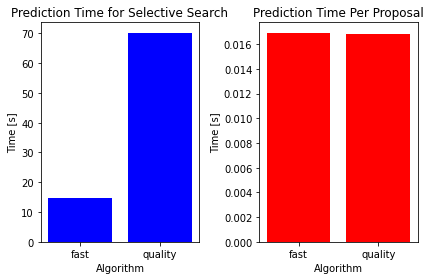

In [26]:
x_label = ['fast', 'quality']
times = [timeFast, timeQuality]
perProposal = [(timeFast / 877), (timeQuality / 4173)]

# create a subplot
plt.subplot(1, 2, 1)
plt.bar(x_label, times, color='blue', label='Raw')
plt.xlabel("Algorithm")
plt.ylabel("Time [s]")
plt.title("Prediction Time for Selective Search")
plt.subplot(1, 2, 2)
plt.bar(x_label, perProposal, color='red', label='Raw')
plt.xlabel("Algorithm")
plt.ylabel("Time [s]")
plt.title("Prediction Time Per Proposal")
plt.tight_layout()

plt.show()

### Prediction Timing
Like we noticed before, the prediction function runs much quicker with fewer regions to analyze. The timing remains linear as we can see in the "prediction time per proposal" being essentially the same between the two. This is showing the time a prediction took for each area we scanned. So, like we found previously, having fewer regions to process we can save valuable time but with the cost of potential loss of accuracy or precision